# Slack update - 3/8/2019

## Import packages

In [34]:
from Bio import Phylo
import matplotlib
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import translate
import re
import pandas as pd
import json
from plotnine import *
import itertools
from scipy.special import comb
import numpy as np
from scipy.stats import kde

## Time-resolved tree

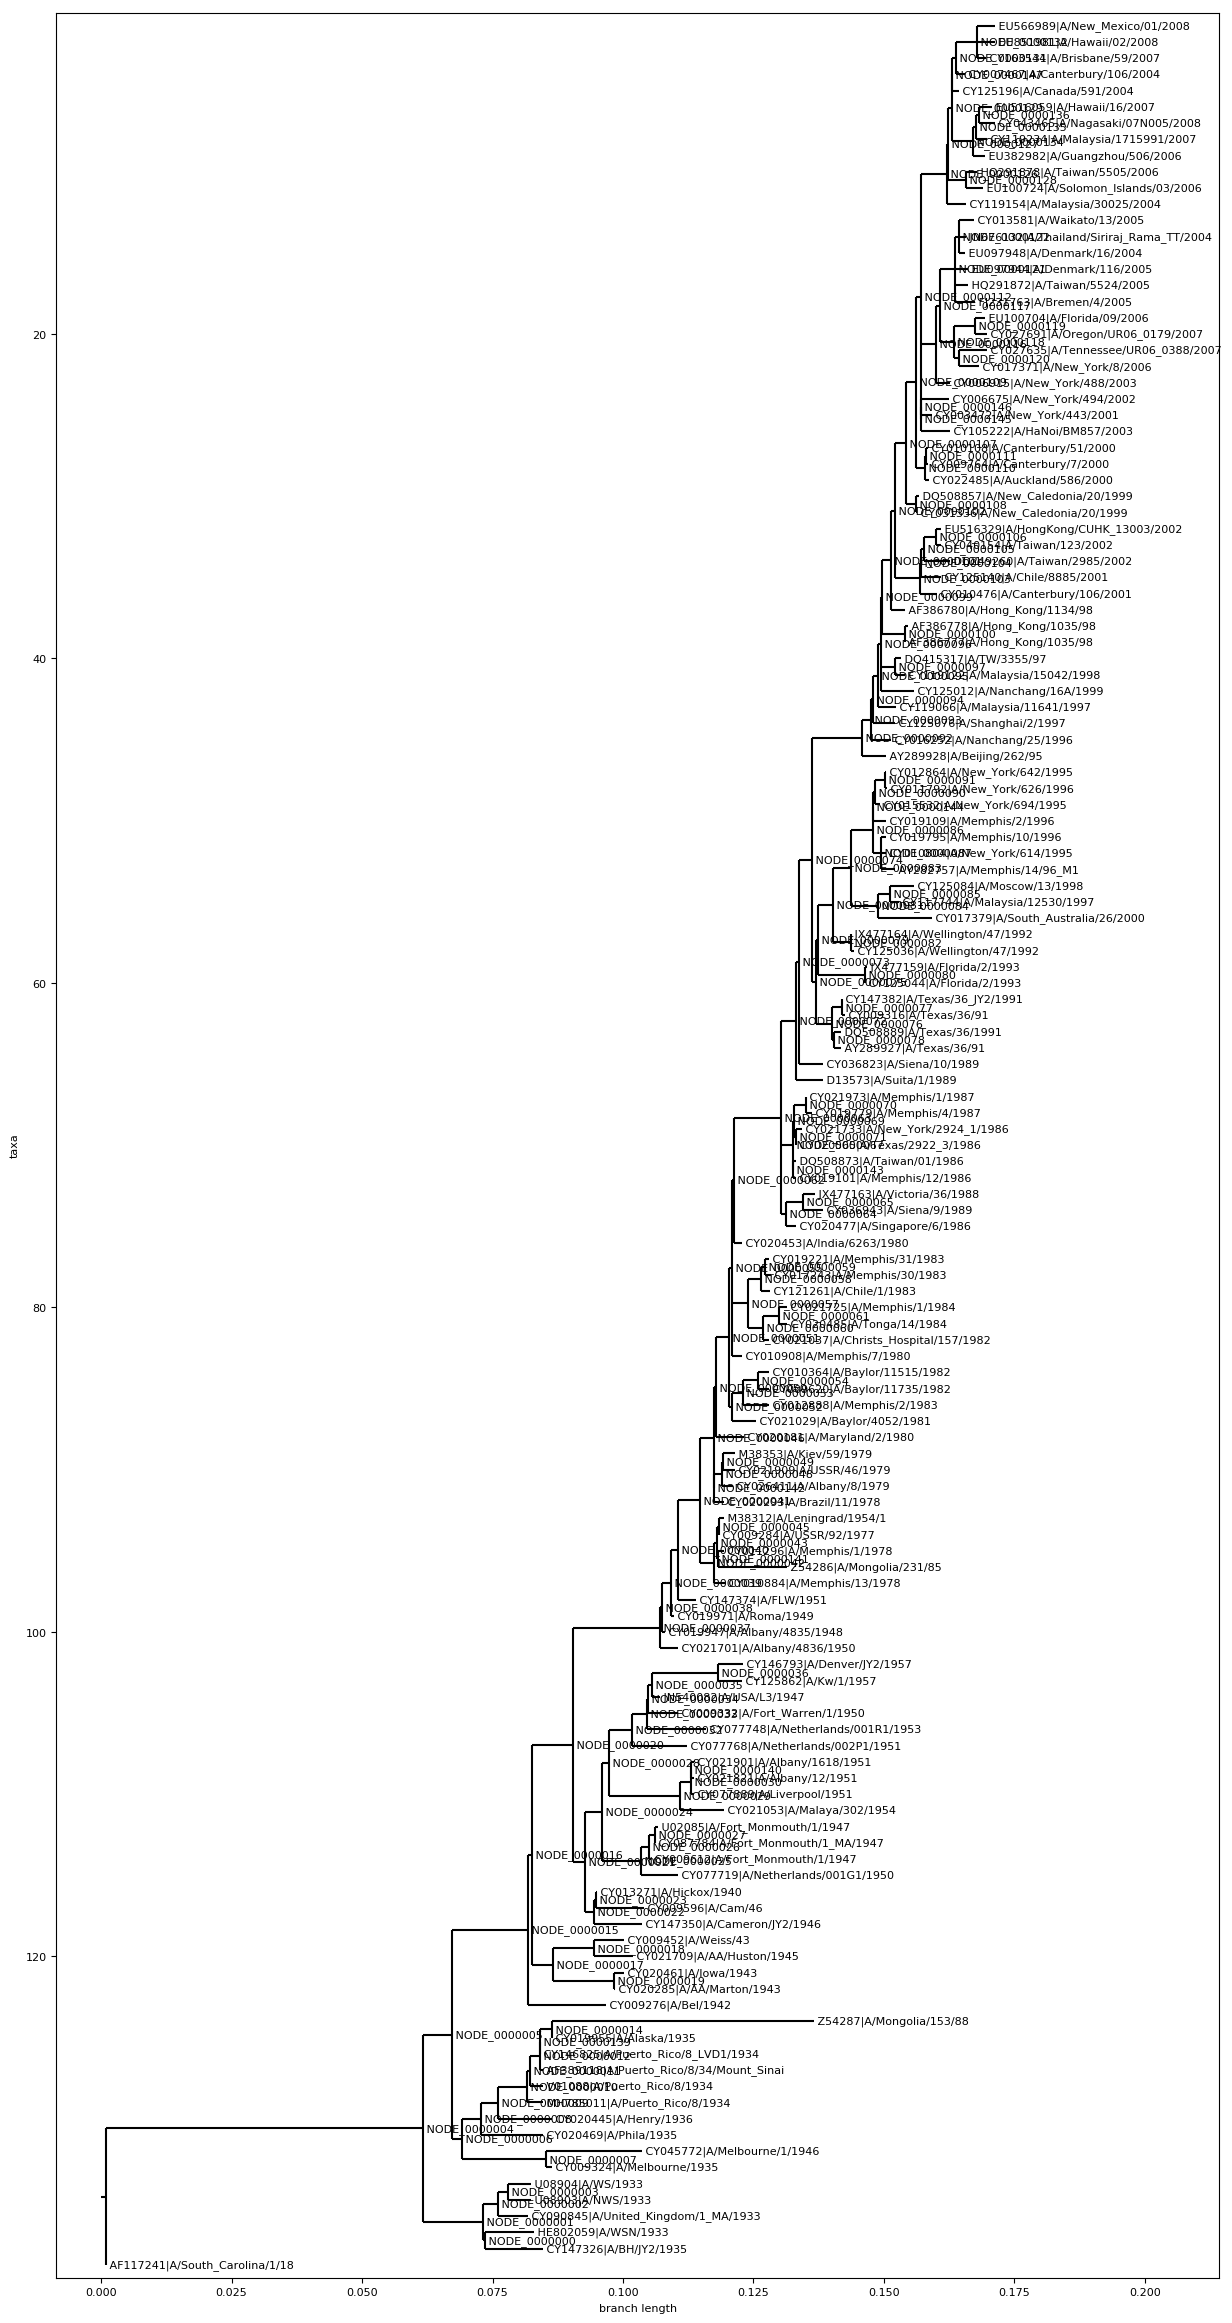

None


In [3]:
tree = Phylo.read("../results/tree-5_removed.nwk", "newick")
matplotlib.rc('font',size=8)
fig = plt.figure(figsize=(15,30), dpi=100)
axes=fig.add_subplot(1,1,1)
tree.ladderize(reverse=True)
tree.root_with_outgroup(outgroup_targets="AF117241|A/South_Carolina/1/18")
print(Phylo.draw(tree, axes=axes))

## Identify amino acid mutations

### Translate NTs to AAs

In [8]:
with open("../influenza-ha/results/nt_muts-5_removed.json") as nt:
    nt_muts = json.load(nt)

strains = []
nt_seqs = []
for strain in nt_muts['nodes'].keys():
    strains.append(strain)
    nt_seqs.append(nt_muts['nodes'][strain]['sequence'])


aa_seqs = []
counter = 0
for seq in nt_seqs:
    aa_seqs.append(translate(seq, gap='-'))
    counter += 1
    
aa_strains = list(zip(strains, aa_seqs))
aa_strains_df = pd.DataFrame(data = aa_strains, columns=['strains', 'aa_seqs'], index = None)

# I realize now I could have just turned aa_strains into a dictionary rather than the pandas df..
aa_dict = aa_strains_df.set_index('strains').T.to_dict()


### Trace tree

In [9]:
# for tip in tree, trace starting at tip and going to South_Carolina 1918 
tree = Phylo.read("../influenza-ha/results/tree-5_removed.nwk", "newick")
traces = []
tips = []
for tip in tree.get_terminals():
    tips.append(tip)
    traces.append(tree.trace(start = tip, finish = "AF117241|A/South_Carolina/1/18"))
    
for trace in traces:
    for clade in trace:
        if clade.name == None:
            trace.remove(clade)

In [10]:
tree = Phylo.read("../influenza-ha/results/tree-5_removed.nwk", "newick")
paths = []
for tip in tree.get_terminals():
    paths.append(tree.get_path(tip))

# Reverse the direction of the paths
index = 0
for path in paths:
    paths[index] = path[::-1]
    index += 1
    
# Distance between 
branch_lengths = []
start_node = []
end_node = []
for tip in paths:
    for parent in tip:
        branch_lengths.append(tree.distance(target1 = tip[0].name, target2 = parent.name))
        start_node.append(tip[0].name)
        end_node.append(parent.name)


total_distances = list(zip(start_node, end_node, branch_lengths))

# df = pd.DataFrame(data = metadata, columns=['id', 'strain', 'year'])
dist_total = pd.DataFrame(data = total_distances, columns=['start_node', 'end_node', 'branch_lengths'])


#### Stepwise distances from tip to parent until root

In [11]:
# for tip in tree, trace starting at tip and going to South_Carolina 1918 
tree = Phylo.read("../influenza-ha/results/tree-5_removed.nwk", "newick")
traces = []
tips = []
for tip in tree.get_terminals():
    tips.append(tip)
    traces.append(tree.trace(start = tip, finish = "AF117241|A/South_Carolina/1/18"))
    
for trace in traces:
    for clade in trace:
        if clade.name == None:
            trace.remove(clade)


start_node = []
end_node = []
branch_id = []
branch_lengths = []
index = 0
for trace in traces:
    prev_node = tips[index].name
    for node in trace:
        branch_lengths.append(node.branch_length)
        start_node.append(prev_node)
        end_node.append(node.name)
        branch_id.append(tips[index].name)
        prev_node = node.name
    index += 1

# Pair strains to amino acid sequences in a dictionary
aa_strains_dict = {}
for key, value in aa_strains:
    aa_strains_dict[key] = value

# Compare sequences, store amino acid mutations in aa_muts list
aa_strains_dict
aa_muts = []
pos = 1
muts = []
for start, ref in zip(start_node, end_node):
    start_seq = aa_strains_dict[start]
    ref_seq = aa_strains_dict[ref]
    
    for aa1, aa2 in zip(start_seq, ref_seq):
        if aa1 == aa2:
#         print(aa1 + str(pos) + aa2)
            pos += 1
        if aa1 != aa2:
            muts.append(aa1 + str(pos) + aa2)
#         print(aa1 + str(pos) + aa2)
            pos += 1
    aa_muts.append(muts)
    muts = []
    pos = 1

stepwise_distances = list(zip(branch_id, start_node,end_node, branch_lengths, aa_muts))
dist_stepwise = pd.DataFrame(data = stepwise_distances, columns=['branch_id','start_node','end_node', 'branch_lengths', 'aa_muts'])
dist_stepwise.to_csv(r'../results/stepwise_mutations-5_removed.csv')

dist_stepwise
print(len(set(dist_stepwise['branch_id'])))

139


## Inchworm

#### Compare all combinations of all mutations for all node-node pairs

In [13]:
import itertools

b_lengths = []
s_node = []
e_node = []
b_id = []
itermuts = []
mut_pairs = []
position = 0
counter = 0
for row in aa_muts:
    if len(row) == 1:
        itermuts.append(row)
    else: 
        itermuts.append(list(itertools.combinations(row, 2)))
    
for i in itermuts:
    if not i or len(i) == 1:
        mut_pairs.append("NA")
        b_lengths.append(branch_lengths[position])
        s_node.append(start_node[position])
        e_node.append(end_node[position])
        b_id.append(branch_id[position])
        position += 1
    else :
        for p in i:
            mut_pairs.append(p)
            b_lengths.append(branch_lengths[position])
            s_node.append(start_node[position])
            e_node.append(end_node[position])
            b_id.append(branch_id[position])
        position += 1

stepwise_mut_pairs = list(zip(b_id, s_node,e_node, b_lengths, mut_pairs))
step_mut_pairs = pd.DataFrame(data = stepwise_mut_pairs, columns=['branch_id','start_node','end_node', 'branch_lengths', 'mut_pairs'])


#### Split mut_pairs

In [15]:
mut1 = []
mut2 = []
site1 = []
site2 = []

for pair in mut_pairs:
    if pair == "NA":
        mut1.append(None)
        mut2.append(None)
        site1.append(None)
        site2.append(None)
    else:
        mut1.append(pair[0])
        mut2.append(pair[1])
        site1.append(pair[0][1:-1])
        site2.append(pair[1][1:-1])
        
stepwise_site_pairs = list(zip(b_id, s_node,e_node, b_lengths, mut1, mut2, site1, site2))
step_site_pairs_na = pd.DataFrame(data = stepwise_site_pairs, columns=['branch_id','start_node','end_node', 'branch_lengths', 'mut1', 'mut2', 'site1','site2'])


#### Remove redundant inchworms

In [18]:
redundant = []
index = 0
inchworm_rmred_na = pd.DataFrame()
red_check = zip(step_site_pairs_na['start_node'], step_site_pairs_na['end_node'], step_site_pairs_na['mut1'], step_site_pairs_na['mut2'])
for pair in red_check:
    
    if pair not in redundant:
        redundant.append(pair)
        inchworm_rmred_na = inchworm_rmred_na.append(step_site_pairs_na.loc[index, :], ignore_index = True)
        index += 1
    else:
        index += 1

inchworm = inchworm_rmred_na.dropna()
inchworm = inchworm.reset_index(drop=True)
inchworm

,branch_id,branch_lengths,end_node,mut1,mut2,site1,site2,start_node
0,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,V5L,4,5,HE802059|A/WSN/1933
1,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,Y10C,4,10,HE802059|A/WSN/1933
2,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,F12L,4,12,HE802059|A/WSN/1933
3,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,V13A,4,13,HE802059|A/WSN/1933
4,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,I36L,4,36,HE802059|A/WSN/1933
5,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,F37L,4,37,HE802059|A/WSN/1933
6,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,A42T,4,42,HE802059|A/WSN/1933
7,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,R53S,4,53,HE802059|A/WSN/1933
8,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,T75A,4,75,HE802059|A/WSN/1933
9,HE802059|A/WSN/1933,0.000389,NODE_0000000,F4R,T144N,4,144,HE802059|A/WSN/1933


#### Mutations per node-pair

In [37]:
# ggplot mutations per node-pair
num_muts = []
redundant = []
for row, pair in zip(aa_muts, zip(start_node, end_node)):
    if pair not in redundant:
        redundant.append(pair)
        num_muts.append(len(row))

num_muts_red = []
for row in aa_muts:
    num_muts_red.append(len(row))
    
num_muts_red_df = pd.DataFrame(num_muts_red, columns = ['mutations_per_branch'])
num_muts_df = pd.DataFrame(num_muts, columns = ['mutations_per_branch'])

This plot includes redundant branches. I originally made this before I wrote the "Remove redundancies" code. It looks like it confirms that I did actually remove redundant branches. 

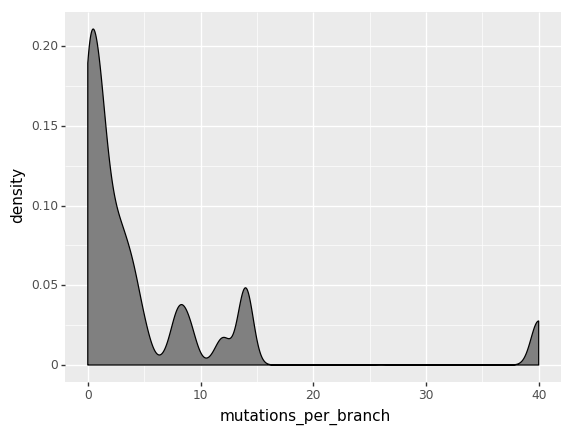

<ggplot: (-9223363288598377072)>


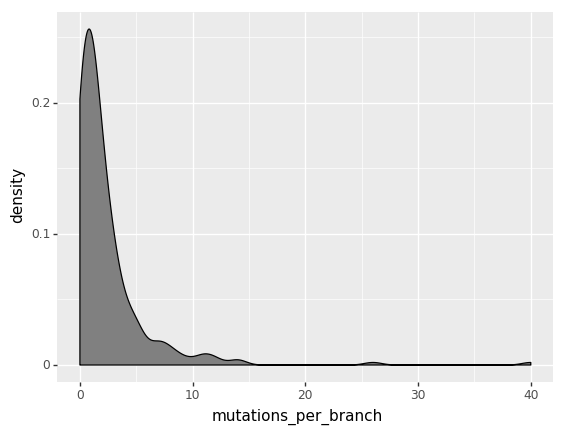

<ggplot: (-9223363288598377016)>


/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../figures/muts_per_branch.png
  warn('Filename: {}'.format(filename))


In [38]:
muts_per_branch_red = ggplot(num_muts_red_df, aes('mutations_per_branch')) + geom_density(fill = 'grey')
print(muts_per_branch_red)

muts_per_branch = ggplot(num_muts_df, aes('mutations_per_branch')) + geom_density(fill = 'grey')
print(muts_per_branch)
muts_per_branch.save(filename="../figures/muts_per_branch.png")

#### Distribution of branch lengths

/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../figures/branch_length_distr.png
  warn('Filename: {}'.format(filename))


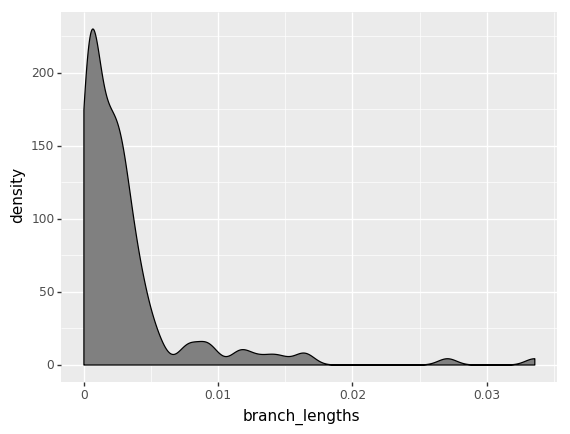

<ggplot: (-9223363288597405629)>


In [39]:
num_blengths = []
redundant = []
for branch, pair in zip(branch_lengths, zip(start_node, end_node)):
    if pair not in redundant:
        redundant.append(pair)
        num_blengths.append(float(branch))
        
num_blengths_df = pd.DataFrame(num_blengths, columns = ['branch_lengths'])

blengths = ggplot(num_blengths_df, aes('branch_lengths')) + geom_density(fill = 'grey')
blengths.save(filename="../figures/branch_length_distr.png")
print(blengths)

#### How many times do mutation sites occur?

/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../figures/num_sites.png
  warn('Filename: {}'.format(filename))


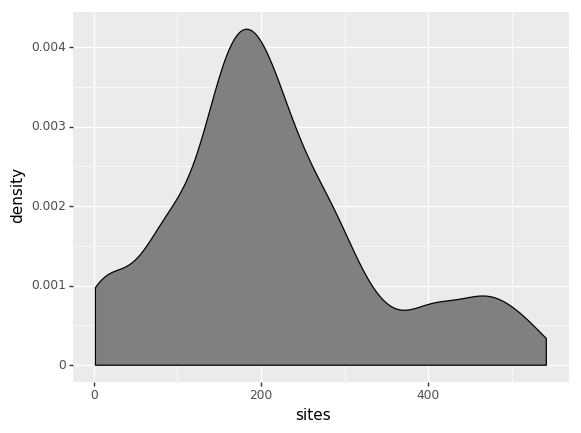

<ggplot: (-9223363288597386103)>


In [40]:
num_sites = []
redundant = []
for row, pair in zip(aa_muts, zip(start_node, end_node)):
    if pair not in redundant:
        redundant.append(pair)
        if row:
            for site in row:
                num_sites.append(int(site[1:-1]))
                
num_sites_df = pd.DataFrame(num_sites, columns = ['sites'])

numsites = ggplot(num_sites_df, aes(x = 'sites')) + geom_density(fill = 'grey')
numsites.save(filename="../figures/num_sites.png")
print(numsites)

#### Number of occurrences of site_pairs
Most times we only see a site pair one time. There are some that we see twice, fewer that we see 3 times, and one that we see 4 times.

/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../figures/site_id_count.png
  warn('Filename: {}'.format(filename))


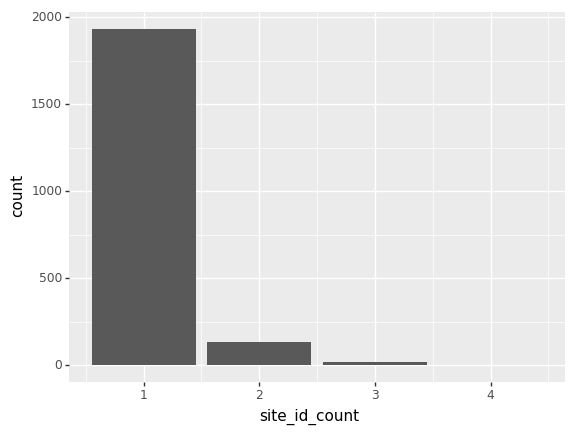

<ggplot: (8748257230463)>

In [41]:
inchworm['site_id'] = inchworm[['site1', 'site2']].apply(lambda x: "{0}_{1}".format(x[0], x[1]) if int(x[0]) < int(x[1]) else "{0}_{1}".format(x[1], x[0]), axis = 1)


inchworm_sitepair_count = inchworm.groupby(['site_id']).count()


count_temp = []
count_site_id = []
for name, group in inchworm.groupby(['site_id']):
    count_temp.append(name)
    count_temp.append(len(group))
    count_site_id.append(count_temp)
    count_temp = []

count_site_id_df = pd.DataFrame(count_site_id, columns = ['site_id','site_id_count'])    

site_id_count = ggplot(count_site_id_df, aes(x='site_id_count')) + geom_bar(stat='count')
site_id_count.save(filename="../figures/site_id_count.png")
site_id_count

##### Add site_id_counts to dataframe

In [42]:
index = 0
inchworm['site_id_count'] = None
for site in inchworm['site_id']:
    for count in count_site_id:
        if site == count[0]:
            inchworm['site_id_count'].iat[index] = count[1]
    index += 1


### Distance matrix from PDB

**Note**: The PDB that Sarah provided to me is based on the WSN strain. Since the WSN strain (aligned to South Carolina 1918) had a gap that caused problems with `Bio.Python.translate()`, Sarah used `PhyDMS` to align my sequences to the WSN strain and translate from NT to AA. We plan on incorporating that step into my pipeline, but have not done so yet.

In [43]:
from dms_tools2.protstruct import distMatrix as dM
equivs = {'B', 'C'}

dist_matrix = dM("../data/1RVX_trimer_sequentialnumbering.pdb",chains = "A", dist_type = "CA", equivchains = equivs)


site1List = inchworm['site1'].tolist()
site2List = inchworm['site2'].tolist()
dists = dist_matrix[1]

dist = []
for site1, site2 in zip(site1List, site2List):
    # The 18 and 502 need to be made generalizable
    # My PDB file starts at amino acid 18 and ends at 502
    if (int(site1) >= 18 and int(site1) <= 502) and (int(site2) >= 18 and int(site2) <= 502):
        # I subtract 18 below because the PDB starts at amino acid 18
        # but my distance matrix starts at index 0
        dist.append(dists[int(site1) - 18][int(site2) - 18])
    else:
        dist.append(None)
inchworm['dist'] = dist

#### Correlation plot

Here's the final product of the `inchworm` approach, colored by number of occurrences of site-pairs

I still need to make a `scrambled` plot to compare this to if I intend to use this quick and dirty method for my rotation talk. I don't think this is the best way, though, because of what we talked about last time: That all branches are not made equal, and that we're not looking at a proper representation of epistasis by limiting ourselves to simultaneous mutations.

/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/layer.py:449: UserWarning: geom_point : Removed 450 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


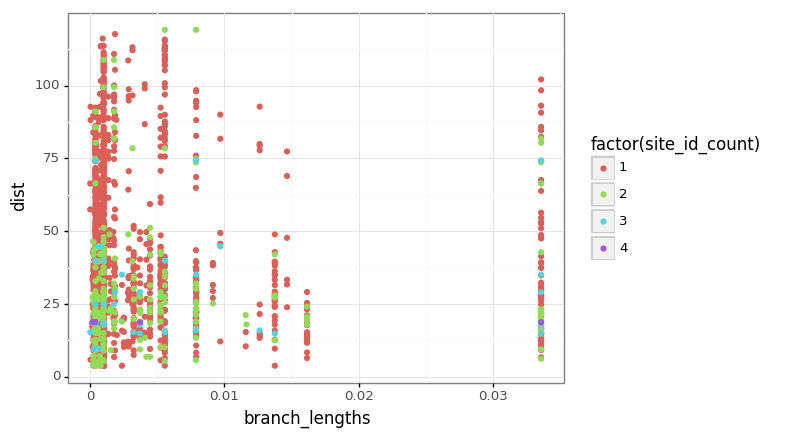

<ggplot: (-9223363298929877020)>

In [27]:
inchworm_corrplot = ggplot(inchworm, aes(x = "branch_lengths", y = "dist")) + geom_point(aes(color='factor(site_id_count)'))
inchworm_corrplot

# alpha = 0.25?

Make a "scrambled" corrplot

## Concatworm

What I would like to do with this is get all combinations of nodes walking up to the root from the tip (child to parent, child to grandparent etc., then parent to grandparent, parent to great-grandparent etc.) and then take the minimum branch length per mutation pair and plot those. This will hopefully give us a more representative sampling of all mutation pairs. 

In [20]:
concatworm_blengths = []
start_n = []
end_n = []
concatworm_branch_id = []
index = 0
redun_check = []
start_end = []
red_start = []
red_end = []
repetition = []
# Lists for all start and end combinations from tip to root
for name, group in dist_stepwise.groupby("branch_id"):
    starts = group.start_node.unique()
    ends = group.end_node.unique()
    tip_id = starts[0]
    index = 0
    for start in starts:
        red_start.append(start)
        for end in ends[index:]:
            red_end.append(end)
            start_end.append(red_start)
            start_end.append(red_end)
            if start_end not in redun_check:
                concatworm_blengths.append(tree.distance(target1 = start, target2 = end))
                start_n.append(start)
                end_n.append(end)
                concatworm_branch_id.append(tip_id)
                redun_check.append(start_end)
                start_end = []
            repetition.append(start_end)
            start_end = []
            red_end = []
        red_start = []
        index += 1

# Mutations from each start to end
aa_muts = []
pos = 1
muts = []
for start, ref in zip(start_n, end_n):
    start_seq = aa_strains_dict[start]
    ref_seq = aa_strains_dict[ref]
    
    for aa1, aa2 in zip(start_seq, ref_seq):
        if aa1 == aa2:
#         print(aa1 + str(pos) + aa2)
            pos += 1
        if aa1 != aa2:
            muts.append(aa1 + str(pos) + aa2)
#         print(aa1 + str(pos) + aa2)
            pos += 1
    aa_muts.append(muts)
    muts = []
    pos = 1

In [21]:
catworm_mut_pairs = list(zip(concatworm_branch_id, start_n, end_n, concatworm_blengths, aa_muts))
catworm_mut_pairs_df = pd.DataFrame(data = catworm_mut_pairs, columns = ['branch_id', 'start_node','end_node', 'branch_lengths', 'aa_muts'])
catworm_mut_pairs_df


,branch_id,start_node,end_node,branch_lengths,aa_muts
0,AF117241|A/South_Carolina/1/18,AF117241|A/South_Carolina/1/18,AF117241|A/South_Carolina/1/18,0.000000,[]
1,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000100,0.000000,[]
2,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000099,0.004382,"[R53S, N197H]"
3,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000096,0.004614,"[R53S, N197H]"
4,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000095,0.005205,"[R53S, L86S, N197H]"
5,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000094,0.006074,"[R53S, L86S, N197H, D238G]"
6,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000093,0.006458,"[R53S, L86S, N197H, D238G]"
7,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000092,0.008186,"[R53S, L86S, S149T, N197H, D238G, A326T]"
8,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000074,0.017875,"[T11A, R53S, L60R, L86S, I88F, V97A, S149T, N1..."
9,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000073,0.020383,"[T11A, Y16D, R53S, L60R, V74I, L86S, I88F, V97..."


In [22]:
# All combinations of mutations
catworm_b_lengths = []
catworm_s_node = []
catworm_e_node = []
catworm_b_id = []
catworm_itermuts = []
catworm_mut_pairs = []
position = 0
counter = 0
for row in aa_muts:
    if len(row) == 1:
        catworm_itermuts.append(row)
    else: 
        catworm_itermuts.append(list(itertools.combinations(row, 2)))

# Add annotation for each combination
for i in catworm_itermuts:
    if not i :
        catworm_mut_pairs.append(None)
        catworm_b_lengths.append(concatworm_blengths[position])
        catworm_s_node.append(start_n[position])
        catworm_e_node.append(end_n[position])
        catworm_b_id.append(concatworm_branch_id[position])
        position += 1
    elif len(i) == 1 and i[0] is not tuple:
        for p in i:
            catworm_mut_pairs.append(p)
            catworm_b_lengths.append(concatworm_blengths[position])
            catworm_s_node.append(start_n[position])
            catworm_e_node.append(end_n[position])
            catworm_b_id.append(concatworm_branch_id[position])
        position += 1
    else :
        for p in i:
            catworm_mut_pairs.append(p)
            catworm_b_lengths.append(concatworm_blengths[position])
            catworm_s_node.append(start_n[position])
            catworm_e_node.append(end_n[position])
            catworm_b_id.append(concatworm_branch_id[position])
        position += 1

stepwise_mut_comb = list(zip(catworm_b_id, catworm_s_node,catworm_e_node, catworm_b_lengths, catworm_mut_pairs))
step_mut_comb = pd.DataFrame(data = stepwise_mut_comb, columns=['catworm_branch_id','catworm_start_node','catworm_end_node', 'catworm_branch_lengths', 'catworm_mut_pairs'])


In [51]:
catworm_mut_pairs = list(zip(concatworm_branch_id, start_n, end_n, concatworm_blengths, aa_muts))
catworm_mut_pairs_df = pd.DataFrame(data = catworm_mut_pairs, columns = ['branch_id', 'start_node','end_node', 'branch_lengths', 'aa_muts'])
catworm_mut_pairs_df


,branch_id,start_node,end_node,branch_lengths,aa_muts
0,AF117241|A/South_Carolina/1/18,AF117241|A/South_Carolina/1/18,AF117241|A/South_Carolina/1/18,0.000000,[]
1,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000100,0.000000,[]
2,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000099,0.004382,"[R53S, N197H]"
3,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000096,0.004614,"[R53S, N197H]"
4,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000095,0.005205,"[R53S, L86S, N197H]"
5,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000094,0.006074,"[R53S, L86S, N197H, D238G]"
6,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000093,0.006458,"[R53S, L86S, N197H, D238G]"
7,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000092,0.008186,"[R53S, L86S, S149T, N197H, D238G, A326T]"
8,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000074,0.017875,"[T11A, R53S, L60R, L86S, I88F, V97A, S149T, N1..."
9,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000073,0.020383,"[T11A, Y16D, R53S, L60R, V74I, L86S, I88F, V97..."


In [52]:
# All combinations of mutations
catworm_b_lengths = []
catworm_s_node = []
catworm_e_node = []
catworm_b_id = []
catworm_itermuts = []
catworm_mut_pairs = []
position = 0
counter = 0
for row in aa_muts:
    if len(row) == 1:
        catworm_itermuts.append(row)
    else: 
        catworm_itermuts.append(list(itertools.combinations(row, 2)))

# Add annotation for each combination
for i in catworm_itermuts:
    if not i :
        catworm_mut_pairs.append(None)
        catworm_b_lengths.append(concatworm_blengths[position])
        catworm_s_node.append(start_n[position])
        catworm_e_node.append(end_n[position])
        catworm_b_id.append(concatworm_branch_id[position])
        position += 1
    elif len(i) == 1 and i[0] is not tuple:
        for p in i:
            catworm_mut_pairs.append(p)
            catworm_b_lengths.append(concatworm_blengths[position])
            catworm_s_node.append(start_n[position])
            catworm_e_node.append(end_n[position])
            catworm_b_id.append(concatworm_branch_id[position])
        position += 1
    else :
        for p in i:
            catworm_mut_pairs.append(p)
            catworm_b_lengths.append(concatworm_blengths[position])
            catworm_s_node.append(start_n[position])
            catworm_e_node.append(end_n[position])
            catworm_b_id.append(concatworm_branch_id[position])
        position += 1

stepwise_mut_comb = list(zip(catworm_b_id, catworm_s_node,catworm_e_node, catworm_b_lengths, catworm_mut_pairs))
step_mut_comb = pd.DataFrame(data = stepwise_mut_comb, columns=['catworm_branch_id','catworm_start_node','catworm_end_node', 'catworm_branch_lengths', 'catworm_mut_pairs'])


### Split mut_pairs

In [23]:
mut1 = []
mut2 = []
site1 = []
site2 = []

for pair in catworm_mut_pairs:
    if not pair:
        mut1.append(None)
        mut2.append(None)
        site1.append(None)
        site2.append(None)
    elif type(pair) != tuple:
        mut1.append(None)
        mut2.append(None)
        site1.append(None)
        site2.append(None)
    else:
        mut1.append(pair[0])
        mut2.append(pair[1])
        site1.append(pair[0][1:-1])
        site2.append(pair[1][1:-1])
        
catworm_mut_comb_pairs = list(zip(catworm_b_id, catworm_s_node,catworm_e_node, catworm_b_lengths, mut1, mut2, site1, site2))
catworm_mut_comb_pairs_na = pd.DataFrame(data = catworm_mut_comb_pairs, columns=['branch_id','start_node','end_node', 'branch_lengths', 'mut1', 'mut2', 'site1','site2'])



### Drop NAs

In [24]:
catworm = catworm_mut_comb_pairs_na.dropna()
catworm = catworm.reset_index(drop=True)
print(len(set(catworm['branch_id'])))
catworm

138


,branch_id,start_node,end_node,branch_lengths,mut1,mut2,site1,site2
0,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000099,0.004382,R53S,N197H,53,197
1,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000096,0.004614,R53S,N197H,53,197
2,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000095,0.005205,R53S,L86S,53,86
3,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000095,0.005205,R53S,N197H,53,197
4,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000095,0.005205,L86S,N197H,86,197
5,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000094,0.006074,R53S,L86S,53,86
6,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000094,0.006074,R53S,N197H,53,197
7,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000094,0.006074,R53S,D238G,53,238
8,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000094,0.006074,L86S,N197H,86,197
9,AF386777|A/Hong_Kong/1035/98,AF386777|A/Hong_Kong/1035/98,NODE_0000094,0.006074,L86S,D238G,86,238


In [25]:
catworm = pd.read_csv('../influenza-ha/results/catworm.csv')

catworm_min = catworm.sort_values("branch_lengths").groupby("site_id", as_index=False).first()
catworm_min


,site_id,Unnamed: 0,branch_id,start_node,end_node,branch_lengths,mut1,mut2,site1,site2
0,100_101,2778925,CY125036|A/Wellington/47/1992,NODE_0000082,NODE_0000138,0.115690,P100S,D101N,100,101
1,100_102,145477,AF386777|A/Hong_Kong/1035/98,NODE_0000074,NODE_0000138,0.108087,P100S,P102S,100,102
2,100_103,987214,CY009324|A/Melbourne/1935,NODE_0000007,NODE_0000138,0.057128,P100S,K103E,100,103
3,100_106,2544647,CY090845|A/United_Kingdom/1_MA/1933,NODE_0000001,NODE_0000138,0.045163,P100S,A106T,100,106
4,100_111,1869322,CY020445|A/Henry/1936,CY020445|A/Henry/1936,NODE_0000138,0.058275,P100S,A111D,100,111
5,100_113,260981,AF386777|A/Hong_Kong/1035/98,NODE_0000020,NODE_0000138,0.062315,P100S,A113I,100,113
6,100_114,1885539,CY020469|A/Phila/1935,CY020469|A/Phila/1935,NODE_0000138,0.056542,P100S,N114D,100,114
7,100_119,3641701,U08903|A/NWS/1933,NODE_0000003,NODE_0000138,0.049807,P100S,K119R,100,119
8,100_124,2539334,CY090845|A/United_Kingdom/1_MA/1933,CY090845|A/United_Kingdom/1_MA/1933,NODE_0000138,0.053797,P100S,T124S,100,124
9,100_125,1531124,CY015532|A/New_York/694/1995,CY015532|A/New_York/694/1995,NODE_0000138,0.121243,P100S,I125V,100,125


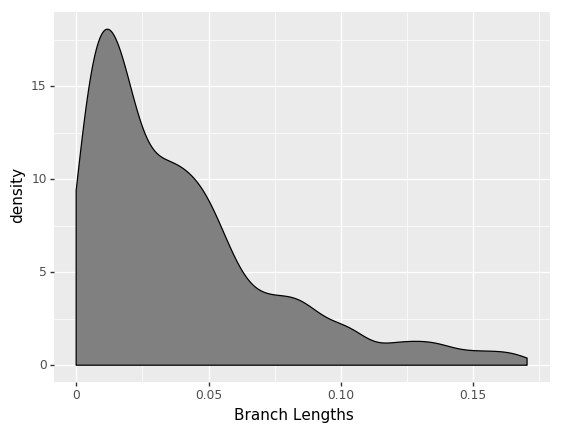

<ggplot: (-9223363305697471179)>


In [27]:
cat_num_blengths = []

for branch, pair in zip(concatworm_blengths, zip(start_n, end_n)):
    cat_num_blengths.append(float(branch))
        
cat_num_blengths_df = pd.DataFrame(cat_num_blengths, columns = ['branch_lengths'])

cat_blengths = ggplot(cat_num_blengths_df, aes('branch_lengths')) + geom_density(fill = 'grey') + xlab('Branch Lengths')
print(cat_blengths)

### Distance matrix from PDB

In [29]:
from dms_tools2.protstruct import distMatrix as dM
equivs = {'B', 'C'}

dist_matrix = dM("../influenza-ha/data/1RVX_trimer_sequentialnumbering.pdb",chains = "A", dist_type = "CA", equivchains = equivs)


site1List = catworm_min['site1'].tolist()
site2List = catworm_min['site2'].tolist()
dists = dist_matrix[1]

dist = []
for site1, site2 in zip(site1List, site2List):
    # The 18 and 502 need to be made generalizable
    # My PDB file starts at amino acid 18 and ends at 502
    if (int(site1) >= 18 and int(site1) <= 502) and (int(site2) >= 18 and int(site2) <= 502):
        # I subtract 18 below because the PDB starts at amino acid 18
        # but my distance matrix starts at index 0
        dist.append(dists[int(site1) - 18][int(site2) - 18])
    else:
        dist.append(None)
catworm_min['dist'] = dist

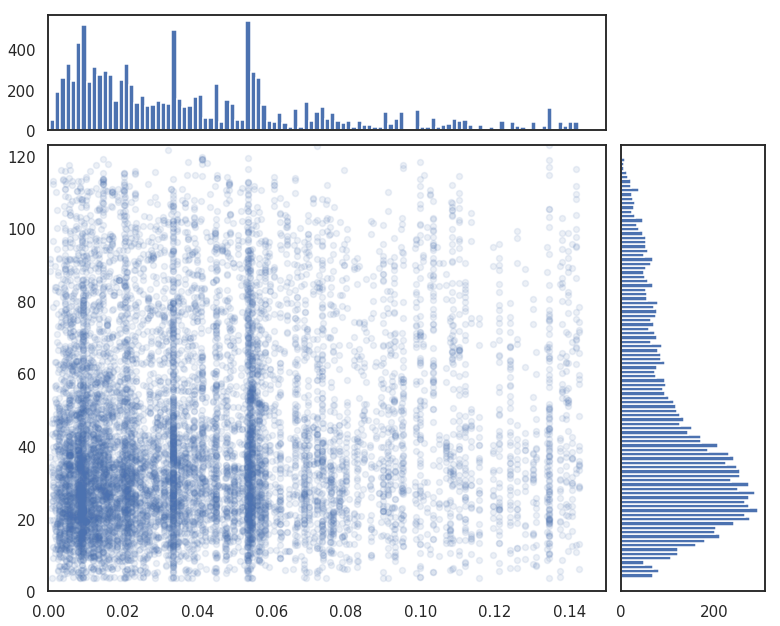

In [32]:
from matplotlib.ticker import NullFormatter

catworm_plt = catworm_min[['branch_lengths', 'dist']].copy()
catworm_plt = catworm_plt.dropna()

nullfmt = NullFormatter()         # no labels

# fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10, 8))
# axes.plot(catworm_plt['branch_lengths'], catworm_plt['dist'],'ko', alpha=0.1)


x=catworm_plt['branch_lengths']
y=catworm_plt['dist']


left, width = 0.125, 0.775
bottom, height = 0.12, 0.775
bottom_h = left_h = left + width + 0.02

rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
rect_scatter = [left, bottom, width, height]

plt.figure(1, figsize=(10, 8))


axScatter = plt.axes(rect_scatter)

axScatter.scatter(x, y, s=35, alpha = 0.1)

axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

binwidth = 0.75

axScatter.set_xlim((0, 0.15))
axScatter.set_ylim((0, 123))

axHistx.hist(x, bins=100)
axHisty.hist(y, bins=100, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim()) 
axHisty.set_ylim(axScatter.get_ylim()) 

plt.show()


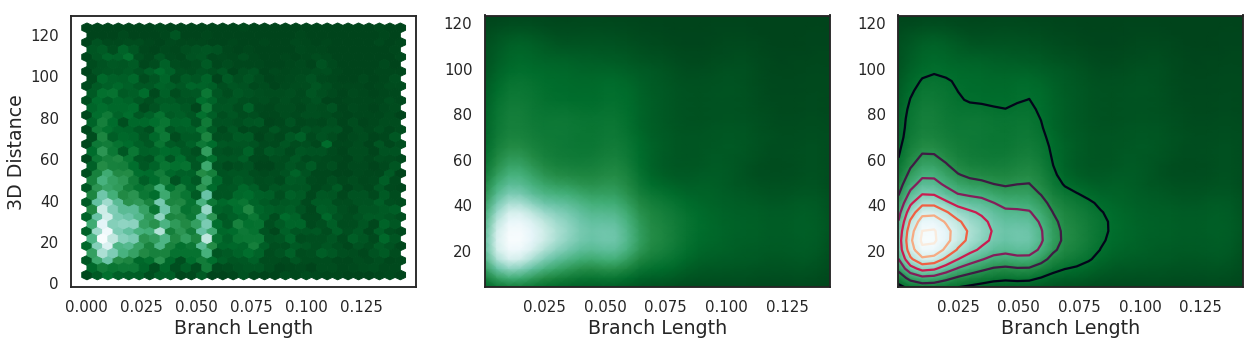

In [36]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(21, 5))


# Thus we can cut the plotting window in several hexbins
nbins = 30
axes[0].hexbin(catworm_plt['branch_lengths'], catworm_plt['dist'], gridsize=nbins, cmap=plt.cm.BuGn_r)
axes[0].set_xlabel('Branch Length')
axes[0].set_ylabel('3D Distance')

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(catworm_plt.T)
xi, yi = np.mgrid[catworm_plt['branch_lengths'].min():catworm_plt['branch_lengths'].max():nbins*1j, catworm_plt['dist'].min():catworm_plt['dist'].max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# add shading
axes[1].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
axes[1].set_xlabel('Branch Length')


# contour
axes[2].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
axes[2].contour(xi, yi, zi.reshape(xi.shape) )
axes[2].set_xlabel('Branch Length')

plt.show()

## Next steps:

* Make a scrambled correlation plot to compare the Catworm plot to
* Tyler suggested plotting the data by binning branch lengths and plotting their average 3D distance on the y-axis
